In [1]:
#generic import and constant definition list
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import h5py
import astropy.constants as cons
from matplotlib.colors import LogNorm
import astropy.units as u
import pandas as pd
import scipy.optimize as opt
#all of the important fundamental constants are put into cgs units just for convenience
c=cons.c.cgs.value
G=cons.G.cgs.value
h=cons.h.cgs.value
hbar=cons.hbar.cgs.value
Msun=cons.M_sun.cgs.value
Rsun=cons.R_sun.cgs.value
Rearth=cons.R_earth.cgs.value
mp=cons.m_p.cgs.value
me=cons.m_e.cgs.value
mn=cons.m_n.cgs.value
kB=cons.k_B.cgs.value
mu_e=2 #mean mass per electron for He-core or C/O core composition
m_u = 1/cons.N_A.cgs.value #atomic mass unit in grams
from astropy.io import fits

In [7]:
data = pd.read_csv('data_3x2420.dat',delim_whitespace=True,header=None,names=['x','y','signal'])
print(data.head())
mesh = np.meshgrid(data['x'],data['y'])

     x    y     signal
0 -5.0 -5.0 -2402.8984
1 -4.0 -5.0 -2391.6408
2 -3.0 -5.0 -2379.0959
3 -2.0 -5.0 -2354.6111
4 -1.0 -5.0 -2364.7074


"In its simplest form the pointing matrix P contains rows - which corresponds to a particular time - with all zeroes in it except for one column with a one (see Figure 5). That column corresponds to the particular pixel observed at the time of interest" -- https://ned.ipac.caltech.edu/level5/Sept05/Hu/Hu5.html

With this in mind I can construct the pointing matrix using pandas' groupby method.


Specifically, with groupby we see that each pixel is observed 20 times. If, for the toy model, we take each pixel's data all at the same time 20 different times then this should just end up being a 20 by 121 matrix with just all 1's. However, if we instead say that pixel data is taken sequentially (so just one pixel at a time) in the order that the values appear in the dat file then that would imply that you have a 2420 by 121 matrix as there are 2,420 observing times.

For now, I will choose the latter option, as this makes more sense with the matrix multiplication we later do.

In [23]:
temp = data.groupby(['x','y'])
print(temp.size())

x     y   
-5.0  -5.0    20
      -4.0    20
      -3.0    20
      -2.0    20
      -1.0    20
              ..
 5.0   1.0    20
       2.0    20
       3.0    20
       4.0    20
       5.0    20
Length: 121, dtype: int64


In [22]:
pointMatrix = np.zeros((2420,121))
for i in range(len(data['signal'])):
    #shift the x and y values by 5 to make them all positive. 
    #we then store the point matrix such that each row corresponds to a time index and each column to a pixel index
    #the pixel indexes are stored in row-major order 
    x = data['x'][i]+5
    y = data['y'][i]+5
    time_index = i
    pixel_index = int(x + y*11)
    pointMatrix[time_index, pixel_index] = 1

In [24]:
pointMatrixT = np.transpose(pointMatrix)
inParentheses = np.matmul(pointMatrixT,pointMatrix)
inverted = np.linalg.inv(inParentheses)

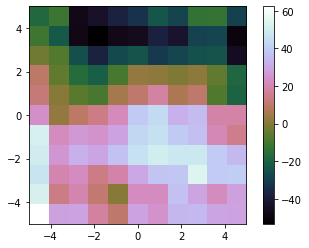

In [40]:
m = np.matmul(inverted,np.matmul(pointMatrixT,data['signal'].values))
plt.imshow(m.reshape(11,11),origin='lower',cmap='cubehelix',extent=(-5,5,-5,5))
plt.colorbar()
plt.show()

note that in my image above there are a few cells (particularly the green cell at (-1,-4)) where their position appears flipped over the x-axis compared to the image in the homework, but generally speaking the broad shapes like the black mass in the upper middle/left corner are in the correct placement so I think it should be fine.

In [41]:
nInverse = pd.read_csv('N_inv_2420x2420.dat',delim_whitespace=True,header=None)
print(nInverse.shape)

(2420, 2420)


In [44]:
pointMatrixT.shape

(121, 2420)

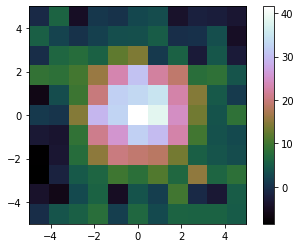

In [45]:
pointMatrixT = np.array(np.transpose(pointMatrix))
pointMatrix = np.array(pointMatrix)
nInverse = np.array(nInverse)
inParentheses = np.matmul(np.matmul(pointMatrixT,nInverse),pointMatrix)
inverted = np.linalg.inv(inParentheses)
m = np.matmul(inverted,np.matmul(pointMatrixT,np.matmul(nInverse,data['signal'].values)))
plt.imshow(m.reshape(11,11),origin='lower',cmap='cubehelix',extent=(-5,5,-5,5))
plt.colorbar()
plt.show()